In [1]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2
import os
from skimage import img_as_bool, io, color, morphology
import math
from scipy import ndimage
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import re

In [2]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, SMOOTH = 1):
    n = outputs.shape[0]
    outputs = outputs.view(n, -1)
    labels = labels.view(n, -1)
    
    intersection = (outputs.round() * labels.round()).sum((1))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs.round()).sum((1)) +(labels.round()).sum(( 1)) - intersection        # Will be zzero if both are 0
    
    iou = ((intersection + SMOOTH) / (union + SMOOTH)).mean()  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou

def dice(outputs, labels, SMOOTH = 1): #: torch.Tensor
    #SMOOTH = 0.1
    n = outputs.shape[0]
    outputs = outputs.view(n, -1)
    labels = labels.view(n, -1)
    
    intersection = (outputs.round() * labels.round()).sum((1)) #sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs.round()).sum((1)) +(labels.round()).sum((1))          # Will be zzero if both are 0
    
    
    return ((2.*intersection+SMOOTH)/(union+SMOOTH)).mean()

In [3]:
def scaled(d):
    return np.divide(d-d.min(), d.max()-d.min(), dtype="float32")

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]


        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)


In [4]:
def normalize_by_reference(input_img, ref_img):
    # Get the minimum and maximum pixel values of the reference image
    ref_min = np.min(ref_img)
    ref_max = np.max(ref_img)

    # Get the minimum and maximum pixel values of the input image
    input_min = np.min(input_img)
    input_max = np.max(input_img)

    # Compute the scaling factors for the input image
    scale_min = (ref_min / input_min) if input_min > 0 else 1
    scale_max = ref_max / input_max

    # Apply the scaling factors to the input image
    normalized_img = input_img * scale_min
    normalized_img = np.where(normalized_img > ref_max, ref_max, normalized_img)
    
    return normalized_img

In [5]:
def lab_denoizer(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    A = cv2.fastNlMeansDenoising(a, None, 4, 7, 21)
    B = cv2.fastNlMeansDenoising(b, None, 4, 7, 21)
    filtered = cv2.fastNlMeansDenoising(l, None, 6, 7, 10)
    #noise = cv2.absdiff(l, filtered)
    #L = cv2.absdiff(l, noise)
    new=cv2.merge((filtered,A,B))
    new= cv2.cvtColor(new, cv2.COLOR_LAB2BGR)
    return new

In [6]:
from skimage import exposure

def im_hist_norm(src, ref_img):
    multi = True if src.shape[-1] > 1 else False
    matched = exposure.match_histograms(src, ref_img, multichannel=multi)
    return matched

In [7]:
def correct_overexposure(imag, channel="green", target_value=210):
    # Get the channel index
    channel_idx = {'blue': 0, 'green': 1, 'red': 2}[channel.lower()]

    # Split the image channels
    #b, g, r = cv2.split(imag)

    # Threshold the selected channel to identify overexposed pixels
    overexposed_pixels = imag[:,:,channel_idx] > target_value

    # Replace the overexposed pixels with the target value
    imag[:,:,channel_idx][overexposed_pixels] = target_value

    # Merge the channels back into a single image
    #normalized_img = cv2.merge([b, g, r])

    return imag #normalized_img

In [8]:
def calculate_rootlen(r,mmcoef_=1, intercept=0):
    a = [] # list of lengths 
    for i in range(r.shape[0]):
        image = np.round(r[i,0,:,:],decimals=0) #y[i,0,:,:]
        #image = cv2.resize(image,(256,256))
        image = img_as_bool(image)
        image = ndimage.binary_closing(image, structure=np.ones((3,3)))
        skeleton = morphology.medial_axis(image)
        sk = np.round(skeleton.sum(), decimals=1)
        ## Correction
        sk = np.round(sk*mmcoef_)+intercept
        #print(sk)
        a.append(sk)
    return a

In [9]:
def calculate_area(r,mmcoef_=1, intercept=0):
    a = [] # list of lengths 
    for i in range(r.shape[0]):
        image = np.round(r[i,0,:,:],decimals=0) #y[i,0,:,:]
        #image = cv2.resize(image,(256,256))
        image = img_as_bool(image)
        image = ndimage.binary_closing(image, structure=np.ones((3,3)))
        
        sk = np.round(image.sum(), decimals=1)
        ## Correction
        sk = np.round(sk*mmcoef_)+intercept
        #print(sk)
        a.append(sk)
    return a

In [10]:
def scaled(d):
    a=d-d.min()
    b=d.max()-d.min()
    return np.divide(a, b, dtype="float32")#,out=np.zeros_like(a), where=b!=0)

def transcal(d):
    d = d.transpose(0,3,1,2)
    return scaled(d)

In [11]:
model = torch.load("./BipEModel_gray")

C:\ProgramData\Anaconda3\envs\Image_processing\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [12]:
model1 = torch.load("./BipEModel3.6")

# Load data

In [13]:
dir0 = "D:/Imaging_PY/Experiments/Biplabi_data/GN-Tube 09/"#"Biplabi_Ivika_data/Original/"#"Biplabi_images/Sept_2020/"#"Biplabi_images/test_20_12_2020/"#"all sessons_GO_T27/24.06/"#same_location_L06/
l = os.listdir(dir0)

In [33]:
main_dir="D:/Imaging_PY/Experiments/Biplabi_images/GN_TUBES/"
tubes = os.listdir(main_dir)
dir0 = main_dir+tubes[8]+"/"
l = os.listdir(dir0)
l

['GN2020M05D23_T017_L001_2020.05.23_181744_001_PS.jpg',
 'GN2020M05D23_T017_L002_2020.05.23_181738_001_PS.jpg',
 'GN2020M05D23_T017_L003_2020.05.23_181731_001_PS.jpg',
 'GN2020M05D23_T017_L004_2020.05.23_181724_001_PS.jpg',
 'GN2020M05D23_T017_L005_2020.05.23_181717_001_PS.jpg',
 'GN2020M05D23_T017_L006_2020.05.23_181710_001_PS.jpg',
 'GN2020M05D23_T017_L007_2020.05.23_181703_001_PS.jpg',
 'GN2020M05D23_T017_L008_2020.05.23_181657_001_PS.jpg',
 'GN2020M05D23_T017_L009_2020.05.23_181650_001_PS.jpg',
 'GN2020M05D23_T017_L010_2020.05.23_181643_001_PS.jpg',
 'GN2020M05D23_T017_L011_2020.05.23_181636_001_PS.jpg',
 'GN2020M05D23_T017_L012_2020.05.23_181629_001_PS.jpg',
 'GN2020M05D23_T017_L013_2020.05.23_181622_001_PS.jpg',
 'GN2020M05D23_T017_L014_2020.05.23_181616_001_PS.jpg',
 'GN2020M05D23_T017_L015_2020.05.23_181609_001_PS.jpg',
 'GN2020M05D23_T017_L016_2020.05.23_181602_001_PS.jpg',
 'GN2020M05D23_T017_L017_2020.05.23_181555_001_PS.jpg',
 'GN2020M05D23_T017_L018_2020.05.23_181548_001_P

In [34]:
# dates 
date_pattern = r"\d{4}\.\d{2}\.\d{2}"  # Regular expression pattern for date in format YYYY.MM.DD
unique_dates = set()

for file_name in l:
    match = re.search(date_pattern, file_name)
    if match:
        date = match.group()
        unique_dates.add(date)

In [49]:
dates_list = list(unique_dates)
dates_list=sorted(dates_list)

In [32]:
dates_list = list(unique_dates)
sorted(dates_list)

['2020.05.26',
 '2020.06.25',
 '2020.07.17',
 '2020.08.12',
 '2020.09.18',
 '2020.10.07',
 '2020.11.24',
 '2021.03.12',
 '2021.04.18',
 '2021.06.20',
 '2021.07.13',
 '2021.08.02',
 '2022.01.13',
 '2022.04.11',
 '2022.06.16',
 '2022.08.18']

In [50]:
dates_list 

['2020.05.23',
 '2020.06.27',
 '2020.07.17',
 '2020.08.12',
 '2020.09.18',
 '2020.10.07',
 '2020.11.24',
 '2021.03.09']

In [51]:
# reference building
#dates_list = list(unique_dates)
pattern = r"_L(\d{3})"
#X = np.zeros(shape=(1,480,640,3), dtype="uint8") #shape=(1,480,640,3)
ref={}
for file_name in l:
    if dates_list[2] in file_name:  # '2020.07.17' for nromalization
        match = re.search(pattern, file_name)
        print(match)
        img = cv2.imread(dir0+file_name)
        img = lab_denoizer(np.flip(img,2))
        img = cv2.resize(img, (640, 480))
        location = match.group(1)
        ref[location] = img
        #X = np.append(X, [img], axis=0)
    
#ref_date = X[1:].copy()


<re.Match object; span=(17, 22), match='_L001'>
<re.Match object; span=(17, 22), match='_L002'>
<re.Match object; span=(17, 22), match='_L003'>
<re.Match object; span=(17, 22), match='_L004'>
<re.Match object; span=(17, 22), match='_L005'>
<re.Match object; span=(17, 22), match='_L006'>
<re.Match object; span=(17, 22), match='_L007'>
<re.Match object; span=(17, 22), match='_L008'>
<re.Match object; span=(17, 22), match='_L009'>
<re.Match object; span=(17, 22), match='_L010'>
<re.Match object; span=(17, 22), match='_L011'>
<re.Match object; span=(17, 22), match='_L012'>
<re.Match object; span=(17, 22), match='_L013'>
<re.Match object; span=(17, 22), match='_L014'>
<re.Match object; span=(17, 22), match='_L015'>
<re.Match object; span=(17, 22), match='_L016'>
<re.Match object; span=(17, 22), match='_L017'>
<re.Match object; span=(17, 22), match='_L018'>
<re.Match object; span=(17, 22), match='_L019'>
<re.Match object; span=(17, 22), match='_L020'>
<re.Match object; span=(17, 22), match='

In [ ]:
# the loop
plt.imshow(ref["024"])

In [ ]:
pattern = r"_L(\d{3})"
X = np.zeros(shape=(1,480,640,3), dtype="uint8") #shape=(1,480,640,3)
Grays = np.zeros(shape=(1,480,640,1), dtype="uint8")
for file_name in l:
    if "2021.03.09" in file_name:
            match = re.search(pattern, file_name)
            location = match.group(1)
            img = cv2.imread(dir0+file_name)
            img = lab_denoizer(np.flip(img,2))
            img = cv2.resize(img, (640, 480))
            im = im_hist_norm(img, ref[location])
                    # normalization
            correct = correct_overexposure(im,"green",target_value=210)
            correct = correct_overexposure(correct,"blue",target_value=210)
            correct = correct_overexposure(correct,"red",target_value=210)
            X = np.append(X, [correct], axis=0)
                    # gray   
            gray = cv2.cvtColor(correct, cv2.COLOR_BGR2GRAY)
            gray = np.expand_dims(gray, axis=2)
            Grays = np.append(Grays, [gray], axis=0)
            print(location)
            plt.imshow(correct)
            plt.show()
X = X[1:]
Grays = Grays[1:]

In [18]:
correct.shape

(480, 640, 1)

In [20]:
X.shape

(26, 480, 640, 1)

In [58]:
X_test = transcal(X)
G_test = transcal(Grays)
out1 = predict_mask(model1,X_test)
out2 = predict_mask(model, G_test)
out3 = scaled(out1+out2)
out3 = (out3>0.3).astype("float32")

In [54]:
X_test = transcal(X)
G_test = transcal(Grays)    
# prediction of masks
out=torch.tensor([])
for i in range(0,X_test.shape[0],1):
    torch.cuda.empty_cache() 
    j=i+1
    #print(j)
    if j==(X_test.shape[0]+1):
        print(j)
        with torch.no_grad():
            outputs = model1(torch.from_numpy(X_test[i:]).cuda()) 
            out = torch.cat((out,outputs.cpu()),0)
    else:
        with torch.no_grad():
            outputs = model1(torch.from_numpy(X_test[i:j]).cuda()) 
            out = torch.cat((out,outputs.cpu()),0)
out = out.cpu().detach().numpy()
out.shape

(26, 1, 480, 640)

In [57]:
def predict_mask(Model,dat):
    out=torch.tensor([])
    for i in range(0,dat.shape[0],1):
        torch.cuda.empty_cache() 
        j=i+1
        #print(j)
        if j==(dat.shape[0]+1):
            print(j)
            with torch.no_grad():
                outputs = Model(torch.from_numpy(dat[i:]).cuda()) 
            out = torch.cat((out,outputs.cpu()),0)
        else:
            with torch.no_grad():
                outputs = Model(torch.from_numpy(dat[i:j]).cuda()) 
            out = torch.cat((out,outputs.cpu()),0)
    out = out.cpu().detach().numpy()
    return out

In [21]:
date_counts = {}
pattern = r"_L(\d{3})"
for date in unique_dates:
    print(date)
    # building datset with same date
    X = np.zeros(shape=(1,480,640,3), dtype="uint8") #shape=(1,480,640,3)
    Grays = np.zeros(shape=(1,480,640,1), dtype="uint8")
    for file_name in l:
        if date in file_name:
            match = re.search(pattern, file_name)
            location = match.group(1)
            img = cv2.imread(dir0+file_name)
            img = lab_denoizer(np.flip(img,2))
            img = cv2.resize(img, (640, 480))
            # gray   
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = np.expand_dims(gray, axis=2)
            Grays = np.append(Grays, [gray], axis=0)
            # normalization
            im = im_hist_norm(img, ref[location])
            correct = correct_overexposure(im,"green",target_value=210)
            correct = correct_overexposure(correct,"blue",target_value=210)
            correct = correct_overexposure(correct,"red",target_value=210)
            X = np.append(X, [correct], axis=0)
    
    X = X[1:]
    Grays = Grays[1:]
    X_test = transcal(X)
    G_test = transcal(Grays)
    
    # prediction of masks
    out1 = predict_mask(model1,X_test)
    out2 = predict_mask(model, G_test)
    out3 = scaled(out1+out2)
    out3 = (out3>0.3).astype("float32")
    
    # claculate lengths and add to date_counts dictionary
    total_lengths=calculate_rootlen(out3)  
    total_area = calculate_area(out3)
    date_counts[date] = [total_lengths,total_area]

2021.07.13


C:\ProgramData\Anaconda3\envs\Image_processing\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """


2020.09.18
2021.03.12
2021.08.02
2022.04.11
2020.08.12
2021.06.20
2020.07.17
2020.11.24
2020.05.26
2022.06.16
2022.08.18
2020.10.07
2022.01.13
2021.04.18
2020.06.25


In [35]:
lengths = {}
areas = {}

for key, value in date_counts.items():
    list1, list2 = value
    lengths[key] = list1
    areas[key] = list2

In [36]:
import pandas as pd
L = pd.DataFrame.from_dict(lengths)
A = pd.DataFrame.from_dict(areas)

In [39]:
L.to_csv("tube09_length.csv")

In [ ]:
A.to_csv("tube09_areas.csv")

# Total root length, depth profile

In [16]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
dates = list(date_counts.keys())
lengths = list(date_counts.values())

In [167]:
def date_filter(d,l,month=0,year=0):
    legend_elements = []
    for i in range(len(d)):
        if month==0 and year==0:
            try:
                line, = plt.plot(l[i],range(0,26))
                legend_elements.append(Line2D([0], [0], color=line.get_color(), label=d[i]))
            except:
                print(len(d[i]))
        elif year==0 and month!=0:
            m = int(d[i].split(".")[1])
            if m == month:
                try:
                    line, = plt.plot(l[i],range(0,26))
                    legend_elements.append(Line2D([0], [0], color=line.get_color(), label=d[i]))
                except:
                    print(len(d[i]))
        elif month==0 and year!=0:
            y=int(d[i].split(".")[0])
            if y == year:
                try:
                    line, = plt.plot(l[i],range(0,26))
                    legend_elements.append(Line2D([0], [0], color=line.get_color(), label=d[i]))
                except:
                    print(len(d[i]))
        else:
            y=int(d[i].split(".")[0])
            m = int(d[i].split(".")[1])
            if y==year and m==month:
                try:
                    line, = plt.plot(l[i],range(0,26))
                    legend_elements.append(Line2D([0], [0], color=line.get_color(), label=d[i]))
                except: 
                    print(len(d[i]))
                
    return legend_elements

Text(0, 0.5, 'Depth (unit)')

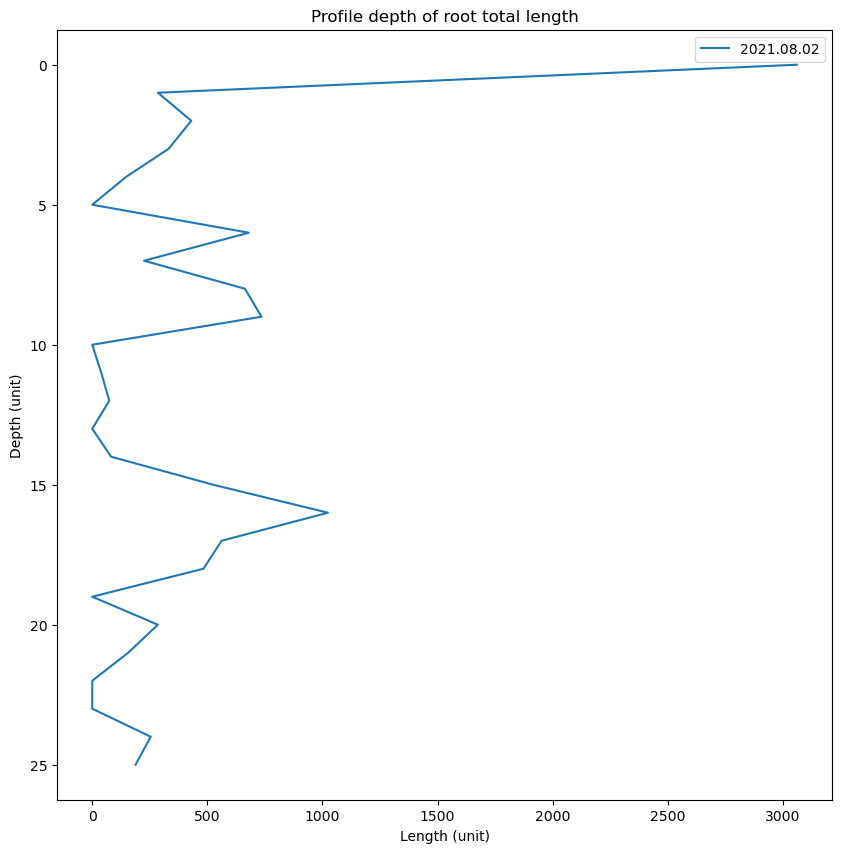

In [170]:
figure(figsize=(10,10))
#legend_elements = []

#for i in range(len(dates)):
    #year = int(dates[i].split(".")[0])
    
    #if year == 2020:
        #print(year)
        #line, = plt.plot(lengths[i],range(0,26))
        #lines.append(line)
        #legend_elements.append(Line2D([0], [0], color=line.get_color(), label=dates[i]))
    
leg_elements=date_filter(dates,lengths,8,2021)
plt.legend(handles=leg_elements)    
plt.gca().invert_yaxis()
plt.title("Profile depth of root total length")
plt.xlabel("Length (unit)")
plt.ylabel("Depth (unit)")

## Correlation plot and regression

In [179]:
dir0 = "Biplabi_data/original/" #"all sessons_GO_T27/24.06/"#"Biplabi_images/Sept_2020/"
l = os.listdir(dir0)
dir2 = "Biplabi_data/mask/" 
l2 = os.listdir(dir2)

In [180]:
X = np.zeros(shape=(1,480,640,3), dtype="uint8") #shape=(1,480,640,3)
Y = np.zeros(shape=(1,480,640,1), dtype="uint8")
#X = []
for i in l:
    img = cv2.imread(dir0+i)
    #
    #img = med_filter(img)
    img = lab_denoizer(np.flip(img,2)) #np.flip(img,2)
    img = cv2.resize(img, (640, 480))
    #print(image_brightness(img))
    X = np.append(X, [img], axis=0)
    #X = np.concatenate((X,img),axis=0)
    #X.append(img)

    print(i)

for i in range(len(l)):
    name = re.split(".jpg", l[i])[0]
    print(name)
    m = name + "_mask_mm_.jpg"
    if m in l2:
        print("Yes")
        img = cv2.imread(dir2+m)
        y = cv2.resize(img, (640, 480))
        #print(image_brightness(img))
        y = np.expand_dims(y[:,:,1], axis=2)
        y = np.expand_dims(y, axis=0)
        print(y.shape)
        Y = np.append(Y, y, axis=0)
        #X = np.concatenate((X,img),axis=0)
        #X.append(img)
    else:
        y = np.zeros(shape=(1,480,640,1), dtype="uint8")
        Y = np.append(Y, y, axis=0)

    print(i)

GN2020M07D21_T041_L006_2020.07.21_152221_001_PS.jpg
GN2020M07D21_T041_L007_2020.07.21_152216_001_PS.jpg
GN2020M07D21_T041_L008_2020.07.21_152211_001_PS.jpg
GN2020M07D21_T041_L009_2020.07.21_152206_001_PS.jpg
GN2020M07D21_T041_L010_2020.07.21_152201_001_PS.jpg
GN2020M07D21_T041_L011_2020.07.21_152156_001_PS.jpg
GN2020M07D21_T041_L012_2020.07.21_152151_001_PS.jpg
GN2020M07D21_T041_L013_2020.07.21_152146_001_PS.jpg
GN2020M07D21_T041_L014_2020.07.21_152141_001_PS.jpg
GN2020M07D21_T041_L015_2020.07.21_152136_001_PS.jpg
GN2020M07D21_T041_L016_2020.07.21_152131_001_PS.jpg
GN2020M07D21_T041_L017_2020.07.21_152126_001_PS.jpg
GN2020M07D21_T041_L018_2020.07.21_152121_001_PS.jpg
GN2020M07D21_T041_L019_2020.07.21_152116_001_PS.jpg
GN2020M07D21_T041_L020_2020.07.21_152111_001_PS.jpg
GN2020M07D21_T041_L021_2020.07.21_152106_001_PS.jpg
GN2020M07D21_T041_L022_2020.07.21_152101_001_PS.jpg
GN2020M07D21_T041_L023_2020.07.21_152056_001_PS.jpg
GN2020M07D21_T041_L025_2020.07.21_152046_001_PS.jpg
GN2020M07D21

GN2020M09D18_T039_L026_2020.09.18_162410_001_PS.jpg
GN2020M09D18_T040_L001_2020.09.18_162748_001_PS.jpg
GN2020M09D18_T040_L002_2020.09.18_162744_001_PS.jpg
GN2020M09D18_T040_L003_2020.09.18_162740_001_PS.jpg
GN2020M09D18_T040_L004_2020.09.18_162736_001_PS.jpg
GN2020M09D18_T040_L005_2020.09.18_162732_001_PS.jpg
GN2020M09D18_T040_L006_2020.09.18_162728_001_PS.jpg
GN2020M09D18_T040_L007_2020.09.18_162724_001_PS.jpg
GN2020M09D18_T040_L008_2020.09.18_162720_001_PS.jpg
GN2020M09D18_T040_L009_2020.09.18_162716_001_PS.jpg
GN2020M09D18_T040_L010_2020.09.18_162712_001_PS.jpg
GN2020M09D18_T040_L011_2020.09.18_162708_001_PS.jpg
GN2020M09D18_T040_L012_2020.09.18_162704_001_PS.jpg
GN2020M09D18_T040_L013_2020.09.18_162700_001_PS.jpg
GN2020M09D18_T040_L014_2020.09.18_162656_001_PS.jpg
GN2020M09D18_T040_L015_2020.09.18_162652_001_PS.jpg
GN2020M09D18_T040_L016_2020.09.18_162648_001_PS.jpg
GN2020M09D18_T040_L017_2020.09.18_162644_001_PS.jpg
GN2020M09D18_T040_L018_2020.09.18_162640_001_PS.jpg
GN2020M09D18

74
GN2020M09D18_T014_L008_2020.09.18_145109_001_PS
Yes
(1, 480, 640, 1)
75
GN2020M09D18_T014_L009_2020.09.18_145105_001_PS
Yes
(1, 480, 640, 1)
76
GN2020M09D18_T014_L010_2020.09.18_145101_001_PS
77
GN2020M09D18_T014_L011_2020.09.18_145057_001_PS
Yes
(1, 480, 640, 1)
78
GN2020M09D18_T014_L012_2020.09.18_145053_001_PS
Yes
(1, 480, 640, 1)
79
GN2020M09D18_T014_L013_2020.09.18_145049_001_PS
Yes
(1, 480, 640, 1)
80
GN2020M09D18_T014_L014_2020.09.18_145045_001_PS
Yes
(1, 480, 640, 1)
81
GN2020M09D18_T014_L015_2020.09.18_145041_001_PS
Yes
(1, 480, 640, 1)
82
GN2020M09D18_T014_L016_2020.09.18_145037_001_PS
Yes
(1, 480, 640, 1)
83
GN2020M09D18_T014_L017_2020.09.18_145033_001_PS
Yes
(1, 480, 640, 1)
84
GN2020M09D18_T014_L018_2020.09.18_145029_001_PS
Yes
(1, 480, 640, 1)
85
GN2020M09D18_T014_L019_2020.09.18_145024_001_PS
Yes
(1, 480, 640, 1)
86
GN2020M09D18_T014_L020_2020.09.18_145020_001_PS
Yes
(1, 480, 640, 1)
87
GN2020M09D18_T014_L021_2020.09.18_145016_001_PS
Yes
(1, 480, 640, 1)
88
GN2020M09D

194
GN2020M09D18_T042_L014_2020.09.18_163726_001_PS
Yes
(1, 480, 640, 1)
195
GN2020M09D18_T042_L015_2020.09.18_163722_001_PS
196
GN2020M09D18_T042_L016_2020.09.18_163718_001_PS
Yes
(1, 480, 640, 1)
197
GN2020M09D18_T042_L017_2020.09.18_163714_001_PS
Yes
(1, 480, 640, 1)
198
GN2020M09D18_T042_L018_2020.09.18_163710_001_PS
Yes
(1, 480, 640, 1)
199
GN2020M09D18_T042_L019_2020.09.18_163706_001_PS
Yes
(1, 480, 640, 1)
200
GN2020M09D18_T042_L020_2020.09.18_163702_001_PS
Yes
(1, 480, 640, 1)
201
GN2020M09D18_T042_L021_2020.09.18_163658_001_PS
Yes
(1, 480, 640, 1)
202
GN2020M09D18_T042_L022_2020.09.18_163654_001_PS
Yes
(1, 480, 640, 1)
203
GN2020M09D18_T042_L023_2020.09.18_163650_001_PS
Yes
(1, 480, 640, 1)
204
GN2020M09D18_T042_L024_2020.09.18_163646_001_PS
Yes
(1, 480, 640, 1)
205
GN2020M09D18_T042_L025_2020.09.18_163642_001_PS
Yes
(1, 480, 640, 1)
206
GN2020M09D18_T042_L026_2020.09.18_163638_001_PS
Yes
(1, 480, 640, 1)
207
GN2020M09D18_T045_L022_2020.09.18_164629_001_PS
Yes
(1, 480, 640, 1)

In [181]:
X = X[1:]
Y = Y[1:]
X_test = transcal(X)
Y_test = transcal(Y)
print(X_test.shape)
print(Y_test.shape)

(224, 3, 480, 640)
(224, 1, 480, 640)


In [182]:
model = torch.load("./BipEModel3.5")

In [183]:
out=torch.tensor([])
for i in range(0,X_test.shape[0],1):
    torch.cuda.empty_cache() 
    j=i+1
    #print(j)
    if j==(X_test.shape[0]+1):
        print(j)
        with torch.no_grad():
            outputs = model(torch.from_numpy(X_test[i:]).cuda()) 
        out = torch.cat((out,outputs.cpu()),0)
    else:
        with torch.no_grad():
            outputs = model(torch.from_numpy(X_test[i:j]).cuda()) 
        out = torch.cat((out,outputs.cpu()),0)
        
out.shape

torch.Size([224, 1, 480, 640])

In [184]:
out = out.cpu().detach().numpy()

In [185]:
predicted=calculate_rootlen(out,1,0) 
human=calculate_rootlen(Y_test,1)

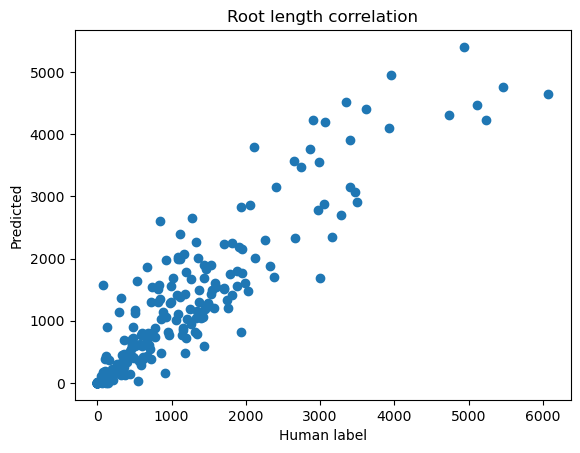

In [114]:
plt.scatter(human, predicted) # 3.5
plt.title("Root length correlation")
plt.ylabel("Predicted")
plt.xlabel("Human label")
plt.show()

In [186]:
from sklearn.linear_model import LinearRegression
mm = LinearRegression(fit_intercept=False)
a = np.array(predicted)
b=np.array(human)
mm.fit(b.reshape(-1, 1),a.reshape(-1, 1))
mm.score(b.reshape(-1, 1),a.reshape(-1, 1))

0.8274848808056977

In [187]:
mm.coef_

array([[1.01108983]])

In [192]:
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
import math
math.sqrt(mean_squared_error(b,a))

502.1058333231579

In [189]:
median_absolute_error(b,a)

207.5

In [190]:
mean_absolute_error(b,a)

337.74107142857144

## Based on color, depth profile

In [21]:
# final function 3 classes
from scipy.stats import mode
from scipy import ndimage 

def scaled(d):
    a=d-d.min()
    b=d.max()-d.min()
    return np.divide(a, b, dtype="float32",out=np.zeros_like(a), where=b!=0)

def fragment(b,num):
    b[b!=num]=0
    #b=scaled(b)
    #print(b.sum())
    return b

def mask_fragments(mask):
    n=np.round(mask)
    n=morphology.remove_small_objects(n.astype("bool"), min_size=10, connectivity=4)
    n=n.astype("float32")
    a, feat = ndimage.label(n[:,:])
    (unique, counts) = np.unique(a, return_counts=True)
    #frequencies = np.asarray((unique, counts)).T
    masks=np.zeros(shape=(1,480,640), dtype="float32")
    for j in range(len(unique)):
        f=fragment(a.copy(),j)
        #print(f.sum())
        masks=np.append(masks,f, axis=0)
    
    #print(lenghts)
    return masks[1:]
'''
def mode_color(im,msk):
    im=im*msk
    gray=im.transpose(1,2,0)[:,:,0]
    g = im.ravel()
    g = g[g>0]
    #mode_pixel = mode(g)
    med=np.nan_to_num(np.median(g))
    print(med)
    nonzero_pixels = np.any(im, axis=0)
    gray[nonzero_pixels] = med#mode_pixel[0]
    return gray'''

def three_root_class(ex_im, ex_mask,ref):
    ex_mask = ex_mask>0.2
    filtr = morphology.remove_small_objects(ex_mask, min_size=80, connectivity=4).astype(int) #dark
    filtr = ndimage.binary_closing(filtr[0], structure=np.ones((5,5)))
    ex_mask=ex_mask*filtr
    im=ex_im*ex_mask
    im = ndimage.median_filter(im, 5, mode="nearest")#########hist normalize this with gray_scale
    im2=gray_scale(im,ref)
    #IMPORTANT, the image should be color corrected
    masks = mask_fragments(ex_mask)
    gray=np.zeros(shape=(480,640), dtype="float32")
    for i in range(masks.shape[0]):
        print(i)
        msk = scaled(masks[i])
        try:
            gray=gray+mode_color(im2, msk) # use im here instead of ex_im, modify mode_color exclude gray_scale
        except:
            pass
    #gray = im.transpose(1,2,0)[:,:,0]#cv2.cvtColor(im.transpose(1,2,0), cv2.COLOR_BGR2GRAY)
    w = gray<0.5 #white
    d = (gray>0.3) & (gray<0.5) #dark/brown
    b = gray<0.3 #black
    res=ex_mask*d
    #res= cv2.medianBlur(res,5)
    res=res>0
    res = morphology.remove_small_objects(res, min_size=80, connectivity=4).astype(int) #dark
    brown = ndimage.binary_closing(res[0], structure=np.ones((5,5)))
    res=ex_mask*b
    res=res>0
    res = morphology.remove_small_objects(res, min_size=80, connectivity=4).astype(int) #dark
    black = ndimage.binary_closing(res[0], structure=np.ones((5,5)))
    G = morphology.remove_small_objects(np.invert(w), min_size=80, connectivity=4).astype(int) #white
    white = ndimage.binary_closing(G, structure=np.ones((5,5)))
    return white, brown, black

In [22]:
def transform(dat):
    result=dat.astype("float32")
    result=np.expand_dims(result, axis=0)
    return result
    
def color_reduction(imdat,mskdat,ref):
    whites=np.zeros(shape=(1,480,640), dtype="float32")
    browns=np.zeros(shape=(1,480,640), dtype="float32")
    blacks=np.zeros(shape=(1,480,640), dtype="float32")
    for i in range(imdat.shape[0]):
        print(i)
        w, d, b= three_root_class(imdat[i],mskdat[i],ref)
        whites = np.append(whites,transform(w), axis=0)
        browns = np.append(browns,transform(d), axis=0)
        blacks = np.append(blacks,transform(b), axis=0)
    return whites[1:], browns[1:], blacks[1:]


In [23]:
def hist_norm(input_img,reference_img ):
    input_hist, _ = np.histogram(input_img.flatten(), 256, [0, 1])
    reference_hist, _ = np.histogram(reference_img.flatten(), 256, [0, 1])

    # Compute the CDFs of both histograms
    input_cdf = input_hist.cumsum()
    input_cdf_normalized = input_cdf * input_hist.max() / input_cdf.max()
    reference_cdf = reference_hist.cumsum()
    reference_cdf_normalized = reference_cdf * reference_hist.max() / reference_cdf.max()

    # Compute the mapping function
    mapping = np.interp(input_cdf_normalized, reference_cdf_normalized, np.arange(0, 1, 1/256)) #np.arange(0, 256)

    # Apply the mapping function to the input image
    normalized_img = mapping[(input_img * 255).astype(np.uint8)]
    return normalized_img.astype("float32")

In [24]:
def gray_scale(img,ref):
    im2= img.transpose(1,2,0)#*255
    #im2 = im2.astype("uint8")
    print(im2.dtype)
    gray=cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    nrom = hist_norm(gray,ref)
    #nrom = nrom.astype("uint8")
    #nrom=scaled(nrom)
    return nrom

In [25]:
def mode_color(im,msk):
    im=im*msk
    im = im.astype("float32")
    print(im.dtype)
    #gray=gray_scale(im,ref) #im.transpose(1,2,0)[:,:,1]
    g = im.ravel()
    #g = scaled(g)
    #g=g.astype("float32")
    g = g[g>0]
    #g = hist_norm(g,ref)
    mode_pixel = mode(g)
    print(mode_pixel[0])
    #nonzero_pixels = np.any(im, axis=0)
    im[im != 0] = mode_pixel[0]
    return im

In [26]:
def reference4hist(im,mask):
    im = im*(mask>0.2)
    im = ndimage.median_filter(im, 5, mode="nearest")
    im2= im.transpose(1,2,0)#*255
    #im2 = im2.astype("uint8")
    reference=cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    return reference

In [64]:
from skimage import exposure

def im_hist_norm(src, ref_img):
    multi = True if src.shape[-1] > 1 else False
    matched = exposure.match_histograms(src, ref_img, multichannel=False)
    return matched



In [247]:
def equalize_hist_rgb(img):
    img_8bit = (img * 255).astype('uint8')

    # Split the image into its 3 color channels
    b, g, r = cv2.split(img_8bit)

    # Equalize the histogram of each channel
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)

    # Merge the equalized channels back into an RGB image
    img_eq = cv2.merge((b_eq, g_eq, r_eq))

    # Convert the equalized image back to a floating point format
    img_eq = img_eq.astype('float32') / 255

    return img_eq

In [248]:
def equalize_lab_histogram(input_img):
    # Convert the RGB image to LAB color space
    input_lab = cv2.cvtColor((input_img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
    
    # Split the LAB image into separate channels
    input_l, input_a, input_b = cv2.split(input_lab)
    
    # Apply histogram equalization to the L channel
    input_l_equalized = cv2.equalizeHist(input_l)
    
    # Merge the equalized L channel with the original A and B channels
    output_lab = cv2.merge([input_l_equalized, input_a, input_b])
    
    # Convert the LAB image back to RGB color space
    output_rgb = cv2.cvtColor(output_lab, cv2.COLOR_LAB2RGB) / 255
    
    return output_rgb

In [69]:
normy=im_hist_norm(X_test[0],X_test[23])

C:\ProgramData\Anaconda3\envs\Image_processing\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """


In [104]:
w, d, b= three_root_class(X_test[7],out[7],ref=ref)#matched.transpose(2,0,1)

float32
0
float32
[]
1
float32
[0.99609375]
2
float32
[0.99609375]
3
float32
[0.99609375]
4
float32
[0.99609375]


C:\ProgramData\Anaconda3\envs\Image_processing\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [98]:
ref=reference4hist(X_test[23],out[23])

In [28]:
whites, browns, blacks = color_reduction(X_test,out,ref)

0
float32
0
float32
[]
1
float32
[0.43290818]
2
float32
[]
3
float32
[]
4
float32
[0.19586247]
5
float32
[0.17390274]
6
float32
[0.0391394]
7
float32
[0.08942691]
8
float32
[0.08942691]
9
float32
[0.37177503]
10
float32
[0.08942691]
11
float32
[]
12
float32
[]
13
float32
[0.3867589]
14
float32
[0.3654334]
15
float32
[0.30148247]
16
float32
[0.19586247]
17
float32
[]
18
float32
[0.40685466]
1
float32
0
float32
[]
1
float32
[0.44379848]
2
float32
[0.00177442]
3
float32
[0.03359899]
4
float32
[0.01712492]
5
float32
[0.01712492]
6
float32
[0.00177442]
7
float32
[0.07723287]
2
float32
0
float32
[]
1
float32
[0.99609375]
2
float32
[0.99609375]
3
float32
[0.99609375]
4
float32
[0.99609375]
5
float32
[0.99609375]
3
float32
0
float32
[]
1
float32
[0.99609375]
2
float32
[0.99609375]
4
float32
0
float32
[]
1
float32
[0.99609375]
2
float32
[0.99609375]
5
float32
0
float32
[]
6
float32
0
float32
[]
1
float32
[0.99609375]
2
float32
[0.99609375]
3
float32
[0.99609375]
4
float32
[0.99609375]
5
float32

In [231]:
browns.shape

(26, 480, 640)

In [239]:
whites.shape

(26, 480, 640)

In [240]:
whites =np.expand_dims(whites, axis=1)
whites_rtl=calculate_rootlen(whites)
whites_rtl

[2276.0,
 3662.0,
 3244.0,
 2050.0,
 1422.0,
 1044.0,
 1102.0,
 1436.0,
 2392.0,
 3147.0,
 2106.0,
 2590.0,
 822.0,
 1422.0,
 1815.0,
 1209.0,
 1028.0,
 1077.0,
 1312.0,
 1230.0,
 114.0,
 254.0,
 99.0,
 812.0,
 970.0,
 2396.0]

In [241]:
browns=np.expand_dims(browns, axis=1)
browns_rtl=calculate_rootlen(browns)
browns_rtl

[46.0,
 104.0,
 82.0,
 142.0,
 68.0,
 0.0,
 14.0,
 90.0,
 0.0,
 0.0,
 801.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 194.0,
 1689.0,
 87.0,
 152.0,
 0.0,
 0.0,
 0.0,
 0.0,
 34.0,
 0.0]

In [242]:
blacks=np.expand_dims(blacks, axis=1)
blacks_rtl=calculate_rootlen(blacks)
blacks_rtl

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]